In [15]:
#

In [16]:
"""
General class architecture:

> We have a number of bench-portfolios
> We have a number of compiled portfolios
> We have their components
> Risks are evaluated either for these portfolios themselves, either for them regarding the benchs

So, let's go
"""
pass

In [17]:
# Here go the benchs

In [18]:
import numpy
from matplotlib import pyplot

In [19]:
N = 10_000

tt = numpy.array(numpy.arange(N))
bench_00_incr = numpy.random.normal(loc=0.02, scale=0.11, size=(N,))
bench_01_incr = numpy.random.beta(a=2, b=2, size=(N,)) - 0.5 + 0.02
bench_00 = numpy.cumsum(bench_00_incr)
bench_01 = numpy.cumsum(bench_01_incr)

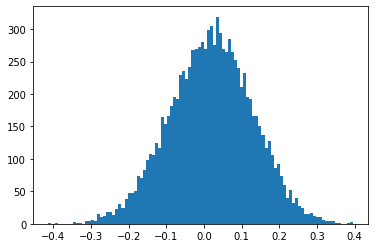

In [20]:
_ = pyplot.hist(bench_00_incr, bins=100)
pyplot.show()

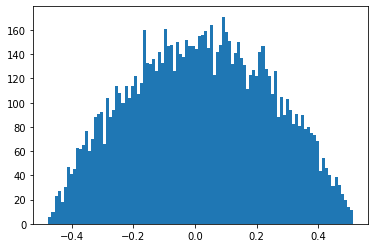

In [21]:
_ = pyplot.hist(bench_01_incr, bins=100)
pyplot.show()

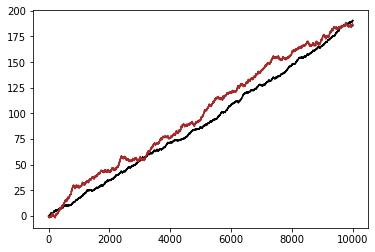

In [22]:
pyplot.plot(tt, bench_00, 'black', tt, bench_01, 'brown')

In [23]:
# Now some portfolios

In [24]:
p00_c00 = numpy.cumsum(numpy.random.normal(loc=0.03, scale=2.2, size=(N,)))
p00_c01 = numpy.cumsum(numpy.random.normal(loc=0.035, scale=2.9, size=(N,)))
p00_c02 = numpy.cumsum(numpy.random.normal(loc=0.01, scale=0.1, size=(N,)))
p00_c03 = numpy.cumsum(numpy.random.normal(loc=0.09, scale=9.2, size=(N,)))

p01_c00 = numpy.cumsum(numpy.random.normal(loc=0.028, scale=2.9, size=(N,)))
p01_c01 = numpy.cumsum(numpy.random.normal(loc=0.031, scale=2.1, size=(N,)))

In [25]:
w00 = [0.2, 0.3, 0.1, 0.4]
p00 = p00_c00 * w00[0] + p00_c01 * w00[1] + p00_c02 * w00[2] + p00_c03 * w00[3]

w01 = [0.7, 0.3]
p01 = p01_c00 * w01[0] + p01_c01 * w01[1]

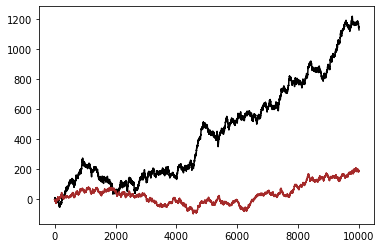

In [26]:
pyplot.plot(tt, p00, 'black', tt, p01, 'brown')

In [27]:
# And finally, apply the routine

In [28]:
def CAPM(portfolio, benchmark, model='OLS', check_pvals=False):
    
    if model == 'OLS': 
        from sklearn.linear_model import LinearRegression as OLS
        model = OLS(n_jobs=-1, fit_intercept=True)
        model.fit(X=portfolio.reshape(-1, 1), y=benchmark)
        if check_pvals:
            raise NotImplemented("Not yet!")
        else:
            alpha, beta = model.intercept_, model.coef_[0]
        
    else:
        raise NotImplemented("Not yet!")
    
    return alpha, beta


def SemiVariance(series):
    
    series_cut = series[series < series.mean()]
    ratio = series_cut.var(ddof=1)
    
    return ratio


def RatioTreynor(portfolio, benchmark, beta):
    
    ratio = (portfolio - benchmark).mean() / beta
    
    return ratio


def RatioSortino(portfolio, benchmark):
    
    semi_deviation = numpy.sqrt(SemiVariance(series=benchmark))
    ratio = (portfolio - benchmark).mean() / semi_deviation
    
    return ratio


def RatioSharpe(portfolio, benchmark):
    
    ratio = (portfolio - benchmark).mean() / benchmark.std(ddof=1)
    
    return ratio


def RatioVaR(portfolio, q):
    
    ratio = numpy.quantile(a=portfolio, q=(1 - q))
    
    return ratio


def RatioCVaR(portfolio, q):
    
    VaR = numpy.quantile(a=portfolio, q=(1 - q))
    portfolio_cut = portfolio[portfolio < VaR]
    ratio = portfolio_cut.mean()
    
    return ratio



In [35]:
class RiskMachine:
    
    def __init__(self):
        
        self.benchs_raw = []
        self.benchs = []
        self.benchs_names = []
        self.portfolios_raw = []
        self.portfolios = []
        self.portfolios_names = []
        
        self.N = None
        self.M = None
        
        self.tt = None
        
        self.ratioAlpha, self.ratioBeta = None, None
        self.ratioTreynor = None
        self.ratioSortino = None
        self.ratioSharpe = None
        self.ratioVaR99 = None
        self.ratioCVaR99 = None
        
    def add_benchs(self, benchs):
        
        for j in range(len(benchs)):
            
            a = benchs[j]
            b = numpy.roll(a, shift=1)
            c = a / b
            c = c[1:]
            self.benchs.append(c)
        
        self.M = len(benchs)
        self.benchs_raw = self.benchs_raw + benchs
    
    def add_portfolios(self, portfolios):
        
        for i in range(len(portfolios)):
            
            a = portfolios[i]
            b = numpy.roll(a, shift=1)
            c = a / b
            c = c[1:]
            self.portfolios.append(c)
            
        self.tt = numpy.array(numpy.arange(portfolios[0].shape[0]))
        
        self.N = len(portfolios)
        self.portfolios_raw = self.portfolios_raw + portfolios
    
    def compute_measures(self):
        
        self.ratioAlpha = numpy.full(shape=(self.N, self.M), fill_value=numpy.nan, dtype=numpy.float64)
        self.ratioBeta = numpy.full(shape=(self.N, self.M), fill_value=numpy.nan, dtype=numpy.float64)
        self.ratioTreynor = numpy.full(shape=(self.N, self.M), fill_value=numpy.nan, dtype=numpy.float64)
        self.ratioSortino = numpy.full(shape=(self.N, self.M), fill_value=numpy.nan, dtype=numpy.float64)
        self.ratioSharpe = numpy.full(shape=(self.N, self.M), fill_value=numpy.nan, dtype=numpy.float64)
        self.ratioVaR99 = numpy.full(shape=(self.N, self.M), fill_value=numpy.nan, dtype=numpy.float64)
        self.ratioCVaR99 = numpy.full(shape=(self.N, self.M), fill_value=numpy.nan, dtype=numpy.float64)
        
        for i in range(self.N):
            for j in range(self.M):
                
                
                self.ratioAlpha[i, j], self.ratioBeta[i, j] = CAPM(portfolio=self.portfolios[i], benchmark=self.benchs[j])
                self.ratioTreynor[i, j] = RatioTreynor(portfolio=self.portfolios[i], benchmark=self.benchs[j], beta=self.ratioBeta[i, j])
                self.ratioSortino[i, j] = RatioSortino(portfolio=self.portfolios[i], benchmark=self.benchs[j])
                self.ratioSharpe[i, j] = RatioSharpe(portfolio=self.portfolios[i], benchmark=self.benchs[j])
                self.ratioVaR99[i, j] = RatioVaR(portfolio=self.portfolios[i], q=0.99)
                self.ratioCVaR99[i, j] = RatioCVaR(portfolio=self.portfolios[i], q=0.99)
    
    def plot(self):
        
        fig, ax = pyplot.subplots(self.N, self.M, figsize=(10, 10), sharex=True, sharey=True)
        
        for i in range(self.N):
            for j in range(self.M):

                ax[i, j].plot(self.tt, self.portfolios_raw[i], color='orange', label='Portfolio {0}'.format(i))
                ax[i, j].plot(self.tt, self.benchs_raw[j], color='navy', label='Benchmark {0}'.format(j))
                ax[i, j].title.set_text('A={0:.2f}    B={1:.2f}\nTR={2:.2f}    SO={3:.2f}    SH={4:.2f}\nVaR={5:.2f}    CVaR={6:.2f}'.format(self.ratioAlpha[i, j], self.ratioBeta[i, j], self.ratioTreynor[i, j], self.ratioSortino[i, j], self.ratioSharpe[i, j], self.ratioVaR99[i, j], self.ratioCVaR99[i, j]))
        fig.show()

    def summary(self):
        
        self.compute_measures()
        self.plot()


<ipython-input-35-fe6b3800cf97>:83: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


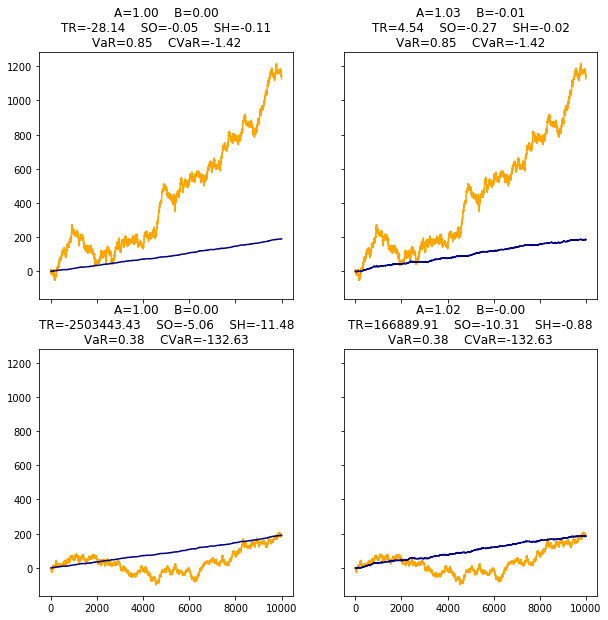

In [36]:
risk_machine = RiskMachine()
risk_machine.add_benchs([bench_00, bench_01])
risk_machine.add_portfolios([p00, p01])
risk_machine.summary()